In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from collections import Counter
import datetime
import pytz
utc=pytz.UTC

In [2]:
notes_file = '../data/notes-00000.tsv'
ratings_file = '../data/ratings-00000.tsv'
hydrated_file = '../data/idtweetVALUES.jsonl'

In [3]:
notes_df = pd.read_csv(notes_file, delimiter='\t')
hydrated_Tweets=pd.read_json(hydrated_file, lines=True)
notes_text_df = pd.merge(notes_df, hydrated_Tweets, left_on='tweetId', right_on='id')
BW_topics = pd.read_csv('../data/BW_tweets_all_Topic.csv')
BW_Topic=pd.merge(notes_text_df,BW_topics,left_on='tweetId',right_on='tweetId')
BW_Topic=BW_Topic[BW_Topic.Topic!='Outlier']
BW_Topic=pd.merge(notes_text_df,BW_topics,left_on='tweetId',right_on='tweetId')

In [4]:
CR=pd.read_json('../data/UpdatedClaimReview/2022_01_14/claim_reviews.json')

CR['joined_text']=CR.claim_text.apply(lambda x: " ".join(x))

CR=CR[CR.joined_text!='']

CR['id']= CR['joined_text'].apply(lambda x: hash(x))

CR=CR.drop_duplicates(subset='id')

CR_topics = pd.read_csv('../data/topic/CR_Updated_Topic_Predicted.csv')

CR_topics=CR_topics[CR_topics.joined_text!='']
CR_topics=CR_topics.drop_duplicates(subset='id')
CR_topics=CR_topics.dropna()

CR_topic_all=pd.merge(CR,CR_topics,left_on='joined_text',right_on='joined_text')
CR_topic_all=CR_topic_all[CR_topic_all.Topic!='Outlier']

In [5]:
d1=BW_Topic[BW_Topic.Topic!='Outlier']['Topic']

In [6]:
d1.value_counts()

Politics        1975
Health          1366
Society          810
Birdwatch        744
Social Media     592
Nature           316
Economy          305
Country          290
Guns             166
Sports           100
Food              45
Security          30
Technology        29
Characters        15
Music             15
Games             15
Harry             14
Name: Topic, dtype: int64

In [7]:
def transform(x):
    if x =='Nature': return 'Natural Disasters'
    if x in ['Harry','Music','Games','Characters','Technology','Security','Food','Sports','Guns']: return 'Other'
    return x

In [8]:
d2=d1.apply(lambda x: transform(x))

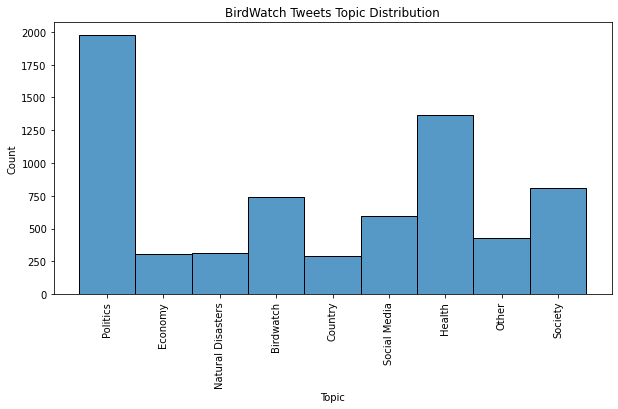

In [9]:
plt.figure(figsize=(10,5))
sns.histplot(d2)
plt.xticks(rotation=90)
plt.title('BirdWatch Tweets Topic Distribution')
plt.savefig('BW_Topic_Dist.png')

In [10]:
def add_date(row):
    dates = [xx['date_published'] for xx in row['reviews']]
    if not dates[0]: return None
    dates = [datetime.datetime.strptime(x,'%Y-%m-%d') for x in dates]
    return utc.localize(min(dates))

CR_topic_all['Time']=CR_topic_all.apply(lambda x: add_date(x),axis=1)

CR_topic_all = CR_topic_all.dropna()

In [11]:
BW_Topic['Time']=BW_Topic.createdAtMillis.apply(lambda x: utc.localize(datetime.datetime.fromtimestamp(x/1000)) )

In [12]:
BW_Topic['Year']=BW_Topic.Time.apply(lambda x: x.year)
BW_Topic['Month']=BW_Topic.Time.apply(lambda x: x.month)

CR_topic_all['Year']=CR_topic_all.Time.apply(lambda x:x.year)
CR_topic_all['Month']=CR_topic_all.Time.apply(lambda x:x.month)

In [13]:
CR_2021 = CR_topic_all[CR_topic_all.Year==2021]
BW_2021 = BW_Topic[BW_Topic.Year==2021]

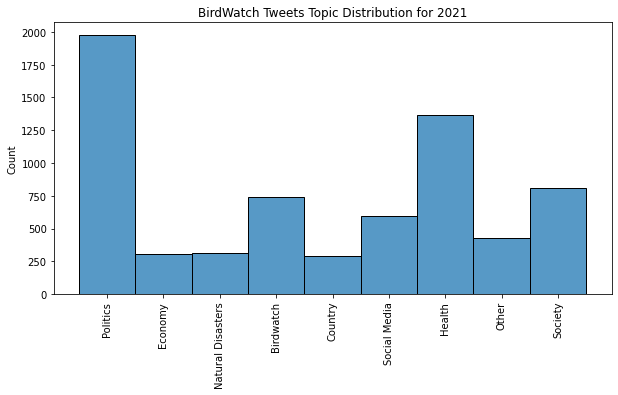

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(BW_2021[BW_2021.Topic!='Outlier'].Topic.apply(lambda x: transform(x)))
plt.xticks(rotation=90)
plt.title('BirdWatch Tweets Topic Distribution for 2021')
plt.xlabel('')
plt.savefig('BW_Topic_Dist.png')

In [15]:
b1=BW_2021[BW_2021.Topic!='Outlier'].drop_duplicates(subset='tweetId').Topic.apply(lambda x: transform(x))

cr1=CR_2021[CR_2021.Topic!='Outlier'].drop_duplicates(subset='joined_text').Topic.apply(lambda x: transform(x))

b2=pd.DataFrame(b1)

b2['Type']='Birdwatch'

cr2=pd.DataFrame(cr1)

cr2['Type']='Claim Review'

data=pd.concat([b2,cr2])

data=data.reset_index()

In [16]:
labels=sorted(set(data.Topic),key=list(data.Topic).index)

In [17]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

/home/barbacou/environments/fact_check/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


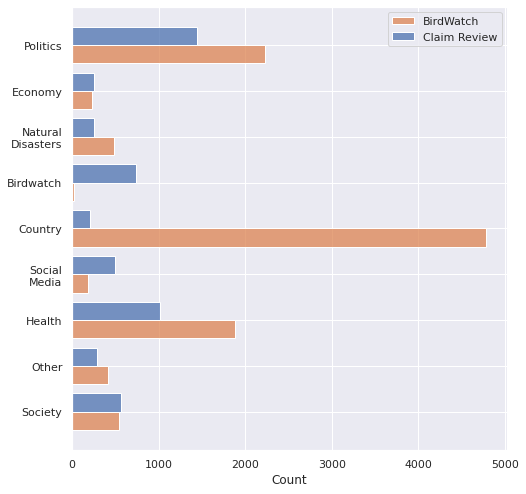

In [18]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(8, 7))
plt.rcParams['font.size'] = '11'
sns.histplot(data=data,y='Topic',hue='Type',multiple='dodge',shrink=0.8)
plt.legend(labels=["BirdWatch","Claim Review"])
plt.ylabel('')
plt.tight_layout()
wrap_labels(ax, 10)
plt.savefig('BW_CR_2021_TopicDist2.png')
plt.show()

/home/barbacou/environments/fact_check/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


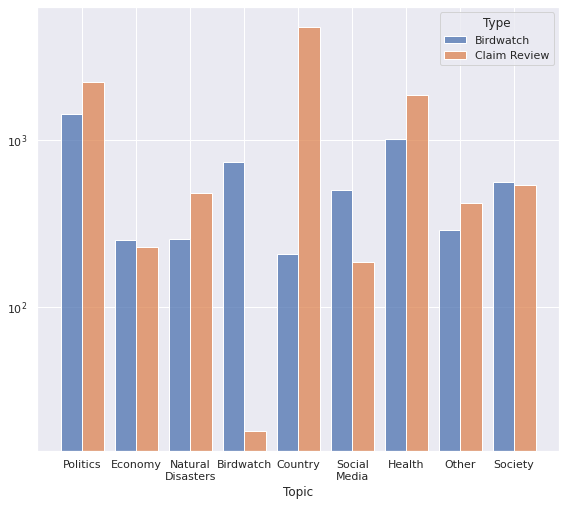

In [19]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)
    
    
sns.set_theme()
fig, ax = plt.subplots(figsize=(8, 7))
plt.rcParams['font.size'] = '11'
g=sns.histplot(data=data,x='Topic',hue='Type',multiple='dodge',shrink=0.8)
ax.set_yscale('log')
#plt.legend(labels=["BirdWatch","Claim Review"])
plt.ylabel('')
plt.tight_layout()
wrap_labels(ax, 10)
#plt.savefig('BW_CR_2021_TopicDist2.png')
plt.show()

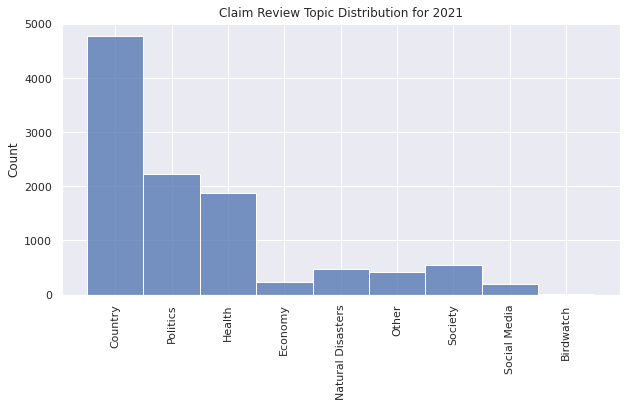

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(CR_2021[CR_2021.Topic!='Outlier'].Topic.apply(lambda x: transform(x)))
plt.xticks(rotation=90)
plt.title('Claim Review Topic Distribution for 2021')
plt.xlabel('')
plt.savefig('CR_Topic_Dist.png')

In [21]:
start_limit = max(min(BW_2021['Time']),min(CR_2021['Time']))
end_limit = min(max(BW_2021['Time']),max(CR_2021['Time']))

In [22]:
BW_range=BW_2021[BW_2021.apply(lambda x: True if start_limit<=x.Time<=end_limit else False,axis=1)]
CR_range=CR_2021[CR_2021.apply(lambda x: True if start_limit<=x.Time<=end_limit else False,axis=1)]

In [23]:
topics = [ 
 'Politics',
 'Economy',
 'Nature',
 'Health',
]

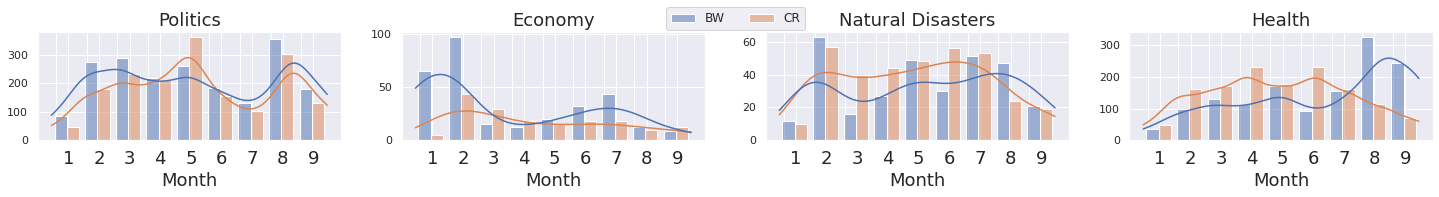

In [24]:
n=len(topics)
fig, axes = plt.subplots(1, n, sharex=True, figsize=(25,2))


for i,t1 in enumerate(topics):
    d1=BW_range[BW_range.Topic==t1]['Month']
    d1=pd.DataFrame(d1)
    d1['Type']='BW'
    d2=CR_range[CR_range.Topic==t1]['Month']
    d2=pd.DataFrame(d2)
    d2['Type']='CR'
    final_data=pd.concat([d1,d2])
    final_data=final_data.reset_index()
    ind1=0 if i<2 else 1
    ind2=0 if not i%2 else 1
    ind1=0
    ind2=i
    sns.set(font_scale = 1.1)
    ax=sns.histplot(ax=axes[ind2],data=final_data,x='Month',hue='Type',multiple='dodge',kde=True,bins=9,shrink=0.8,legend=True)
    mids = [rect.get_x() + rect.get_width() / 8 for rect in ax.patches]
    mids2=[(mids[i]+mids[i+1])/2 for i in range(len(mids)-1)]

    ax.set_xticks(mids)
    ax.set_title('Natural Disasters' if t1=='Nature' else t1,fontsize=18)
    ax.set_xticklabels(list(range(1,10))+['']*(len(mids)-9),fontsize=18)
    ax.set_ylabel('')
    ax.set_xlabel('Month',fontsize=18)
    if ind1==0 and ind2==0:
        saved_ax=ax

    else: ax.get_legend().remove()



sns.move_legend(saved_ax, "upper right",bbox_to_anchor=(2.55, 1.28), title='',ncol=2)
plt.savefig('TopicPlots.png',dpi=100, bbox_inches = 'tight')
plt.show()